## Final Project Submission

Please fill out:
* Student name: Pedro Jofre Lora
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Eli Thomas
* Blog post URL:


# Modeling King County Housing Prices Using MLR Supported with Cross-Validated RFE.
### Table of Contents
1. [Introduction](#1) <br>
2. [Importing and Cleaning Data](#2) <br>
3. [Exploring and Modifying Data](#3) <br>
4. [Modeling Data](#4) <br>
5. [Interpreting Data](#5)

<a id="1"></a>
## 1. Introduction
This is the introduction where you explain the relevant information given the question that was asked. 

<a id="2"></a>
## 2. Importing and cleaning data (Obtain and Scrub)
### 2.1 Importing Data

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')

# Import the data
kc = pd.read_csv('kc_house_data.csv', index_col = 'id')
kc.columns = [col_name.title() for col_name in list(kc.columns)]
kc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
Date             21597 non-null object
Price            21597 non-null float64
Bedrooms         21597 non-null int64
Bathrooms        21597 non-null float64
Sqft_Living      21597 non-null int64
Sqft_Lot         21597 non-null int64
Floors           21597 non-null float64
Waterfront       19221 non-null float64
View             21534 non-null float64
Condition        21597 non-null int64
Grade            21597 non-null int64
Sqft_Above       21597 non-null int64
Sqft_Basement    21597 non-null object
Yr_Built         21597 non-null int64
Yr_Renovated     17755 non-null float64
Zipcode          21597 non-null int64
Lat              21597 non-null float64
Long             21597 non-null float64
Sqft_Living15    21597 non-null int64
Sqft_Lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(2)
memory usage: 3.5+ MB


In [2]:
pd.DataFrame(
    data = kc.nunique().sort_values(), 
    columns = ['Counts']
    ).transpose()

,Waterfront,Condition,View,Floors,Grade,Bedrooms,Bathrooms,Zipcode,Yr_Renovated,Yr_Built,Sqft_Basement,Date,Long,Sqft_Living15,Sqft_Above,Sqft_Living,Price,Lat,Sqft_Lot15,Sqft_Lot
Counts,2,5,5,6,11,12,29,70,70,116,304,372,751,777,942,1034,3622,5033,8682,9776


In [3]:
kc.describe()

,Price,Bedrooms,Bathrooms,Sqft_Living,Sqft_Lot,Floors,Waterfront,View,Condition,Grade,Sqft_Above,Yr_Built,Yr_Renovated,Zipcode,Lat,Long,Sqft_Living15,Sqft_Lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### 2.2 Define problems
1.  Date, View, and Sqft_basement are incorrect types.
2.  Waterfront and zipcode likely need to be converted to categorical.
3.  Condition and Grade might need to be converted to categorical, unless the numbers are a monotonic scale (scale of 1-5 with 5 being the "best").
4.  Investigate Yr_Renovated.
5.  Deciding what to do with the date.
6.  Deciding what to do with the lat and long values.

Data could be dropped from View, and it should also be converted to a binary category since the description is "has been viewed", and not "the number of times the propery has been viewed".

Waterfront and zipcode may not need to be converted to categorical and could be tossed out if the distributions of the groups is equal. If the distributions are not equal then they'll both be changed to categorical. It might be best to run separate analyses for the categories if there's enough data, since the relationships may change in shape given the value of a category.

Condition and Grade likely will not need to be converted to categorical, though we must assume that they are monotonic scales.

There is a surprisingly low mean and a very high std for Yr_Renovated, which may indicate that the data may not accurately represent what's going on. It may be the case that very few homes have renovations on file. If this is the case, then Yr_renovated should be changed to Renovated, which is a binary category indicating whether or not a renovation is on file.

The date will likely have a large impact on predicting the final sale price. I'll investigate to see if there is an impact, and then decide what to do.

Changing Lat and Long data into rectangular sectors can approximate neighborhoods that can then be used as categories. It would be best to look at a map of king county to see if there are distinct neighborhoods that could be drawn instead. This would be an interesting function...


### 2.3 Resolving problems
#### 2.3.1. Change Date and Sqft_Basement to correct types. Drop Data as necessary. Make a separate Basement as a category.

In [4]:
kc.Sqft_Basement.replace(to_replace = '?', 
                         value = np.nan, 
                         inplace = True)
kc.Sqft_Basement = kc.Sqft_Basement.apply(pd.to_numeric)
kc = kc[kc.Sqft_Basement.notnull()]
kc = kc[kc.View.notnull()]
kc.View = kc.View.where(kc.View <= 0, other = 1)
kc['View'] = (kc.View > 0).astype('category')

In [5]:
kc['Basement'] = (kc.Sqft_Basement>0).astype('category')

In [6]:
kc.Date = pd.to_datetime(kc.Date)

#### 2.3.2 Change Waterfront and zipcode to categories if appropriate

In [7]:
waterfront_grouping = kc.groupby(by = 'Waterfront')
waterfront_grouping.groups.keys()

dict_keys([0.0, 1.0])

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

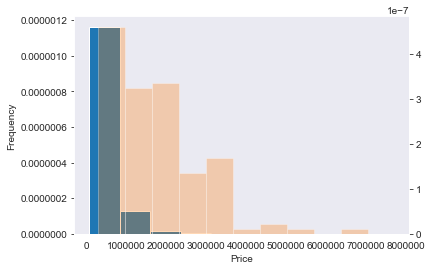

In [9]:
sns.set_style(style = 'dark')
ax1 = waterfront_grouping.get_group(0).Price.plot.hist(density = True)
waterfront_grouping.get_group(1).Price.plot.hist(density = True,
                                            secondary_y = True,
                                            alpha = 0.3,
                                            ax = ax1)
ax1.set_xlabel('Price')
plt.show()

The distributions are clearly different in shape, so waterfront will be converted to a category.

In [10]:
kc.Waterfront.fillna(0.0,inplace = True) # Assume that a null listing means the house is not waterfront
kc.Waterfront = (kc.Waterfront>0).astype('category')

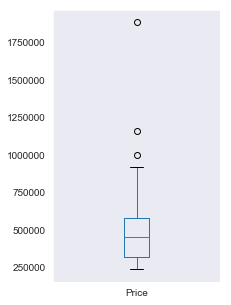

In [11]:
kc.groupby('Zipcode').Price.median().plot.box(figsize = (3,5));

The medians of the groups are too spread out to believe that zipcode might not have a significant impact on the final price of the house. It will be converted to a category.

In [12]:
kc.Zipcode = kc.Zipcode.astype('category')

#### 2.3.3 Changing Grade and Condition to categories.

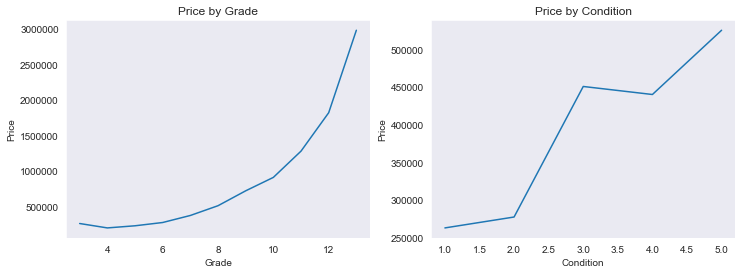

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
kc.groupby('Grade').Price.median().plot(ax = ax1, title = 'Price by Grade');
kc.groupby('Condition').Price.median().plot(ax = ax2, title = 'Price by Condition')
ax1.set_ylabel('Price')
ax2.set_ylabel('Price')
plt.show()

Price as a function of Condition is not easily approximated by a simple function, though this is odd. I'll investigate price by condition more closely to see if there's a reason behind the deviation.

In [14]:
kc.groupby('Condition').Price.agg(['count','max','min','mean','median'])

,count,max,min,mean,median
Condition,,,,,
1,28,1500000.0,78000.0,337801.785714,262500.0
2,166,2560000.0,80000.0,324541.801205,277000.0
3,13688,7060000.0,82000.0,542820.430523,450650.0
4,5538,7700000.0,89000.0,519579.568978,439972.5
5,1662,3650000.0,110000.0,612872.954272,525444.0


The min and max follow a monotonically increasing trend. The scale is most likely meant to be monotonic, so I'll treat it as such and leave Condition as a numerical feature. 

It is also strange that the lowest value for Grade has a higher price than the two following values for grade. I'll also investigate that further.

In [15]:
kc.groupby('Grade').Price.agg(['count','max','min','mean','median'])

,count,max,min,mean,median
Grade,,,,,
3,1,262000.0,262000.0,2.620000e+05,262000.0
4,27,435000.0,80000.0,2.120019e+05,200000.0
5,235,795000.0,78000.0,2.500485e+05,229950.0
6,1991,1200000.0,82000.0,3.024106e+05,276000.0
7,8762,2050000.0,90000.0,4.023335e+05,375000.0
8,5922,3070000.0,140000.0,5.435257e+05,512250.0
9,2546,2700000.0,230000.0,7.741851e+05,721750.0
10,1108,3600000.0,316000.0,1.071458e+06,910500.0
11,389,7060000.0,420000.0,1.494643e+06,1280000.0


There is only one record for a house with a grade of 3. This record will be eliminated since we don't know if this house is an outlier.

In [16]:
kc.drop(kc.loc[kc.Grade == 3].index, inplace = True)

#### 2.3.4  Changing Yr_Renovated to Yrs_Since_Renovation.
This is relatively straightforward. The complicated part is that many of the homes have a value of 0.0 for the year renovated, which is nonsensical. It would be good to investigate how many homes have a renovation date on record.

In [17]:
num_unknown_rennovations = kc.Yr_Renovated.replace(to_replace = 0,
                                                   value = np.nan).isna().sum()
num_renovated = (len(kc) - num_unknown_rennovations)
'The number of houses with documented renovations is {0:G}'.format(num_renovated)

'The number of houses with documented renovations is 722'

Since there are so few homes and so many features, I don't think it makes sense to treat this as a continuous variable for those homes that have been renovated.

In [18]:
kc.Yr_Renovated.fillna(0, inplace = True)
kc['Renovated'] = kc.Yr_Renovated.where(kc.Yr_Renovated <= 0, other = 1)
kc['Renovated'] = (kc.Renovated > 0).astype('category')
kc.drop(labels = 'Yr_Renovated', axis = 1, inplace = True)

#### 2.3.5 Dealing with the date.

My inclination here is that prices are higher in the summer months because demand is higher. I'll look at a 30 day rolling window to spot trends in the median price, and also resample the data by month to also look for trends.

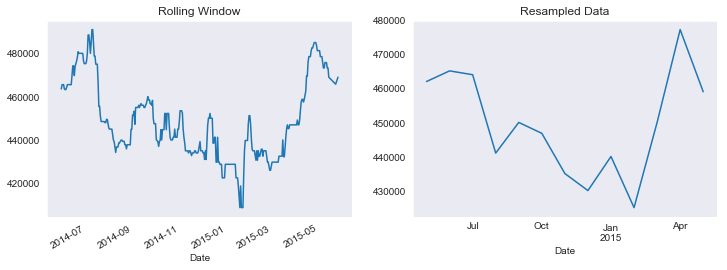

'The maximum swing in adjusted price is 11.61%'

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))
kc.groupby('Date').Price.median().rolling(30).median().plot(ax = ax1, title = 'Rolling Window')
kc.reset_index().set_index(['Date']).resample('m').Price.median().plot(ax = ax2, title = 'Resampled Data')
plt.show()

# Calculate the maximum 'swing' in price as compared to the median
price_adjustment = (kc.reset_index().set_index(['Date']).resample('m').Price.median() / kc.Price.median() - 1)*100
max_swing = price_adjustment.max()-price_adjustment.min()
'The maximum swing in adjusted price is {0:2.2f}%'.format(max_swing)

The maximum swing on the median price is a hefty 11.61%! The model will have to account for the time of the year in order to be more accurate. The easiest way to do this will be to resample by month and then turn into a category. Complexity can be added to the model later by fitting a function to the date, instead of simply categorizing by month.

In [20]:
kc['Month'] = kc.Date.dt.month_name().astype('category')
kc.drop('Date', axis = 1, inplace = True)

#### 2.3.6 Deciding what to do with lat and long values

Here's a map of King County with zip-code boundaries:
<img src="https://www.kingcounty.gov/~/media/operations/GIS/maps/vmc/images/zipcodes_westKC_586.ashx?la=en" alt="An image of King County with zip-code boundaries" title="King Country Zip Codes" />
<br><br><br>
And, for comparison's sake, here's a map of Manhattan with zip-code boundaries:
<img src="https://www.propertyshark.com/Real-Estate-Reports/wp-content/uploads/2012/10/infographic-zip-codes-3.png" alt="An image of Manhattan with zip-code boundaries" title="Manhattan Zip Codes" />

Zip code boundaries trace a mixture of natural boundaries and, I suspect, socioeconomic boundaries. This is corroborated by the Manhattan zipcodes, where neighborhoods are roughly approximated by zip codes (I live in NYC, so I'm more familiar with the neighborhoods here). Though zip codes are not a perfect stand-in for neighborhoods, they are adequate for a first pass at this model. If I have time, I will attend to making discrete quadrants that better capture pricing at the neighborhood level. 


In [21]:
kc.drop(labels = ['Lat', 'Long'], axis = 1, inplace = True)

To finish up importing the data, I'll check the metadata again:

In [22]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21081 entries, 7129300520 to 1523300157
Data columns (total 19 columns):
Price            21081 non-null float64
Bedrooms         21081 non-null int64
Bathrooms        21081 non-null float64
Sqft_Living      21081 non-null int64
Sqft_Lot         21081 non-null int64
Floors           21081 non-null float64
Waterfront       21081 non-null category
View             21081 non-null category
Condition        21081 non-null int64
Grade            21081 non-null int64
Sqft_Above       21081 non-null int64
Sqft_Basement    21081 non-null float64
Yr_Built         21081 non-null int64
Zipcode          21081 non-null category
Sqft_Living15    21081 non-null int64
Sqft_Lot15       21081 non-null int64
Basement         21081 non-null category
Renovated        21081 non-null category
Month            21081 non-null category
dtypes: category(6), float64(4), int64(9)
memory usage: 2.4 MB


That looks significantly better now. Some series' types could be changed to improve efficiency, but I'm not worried about it at this point since the dataframe is small.

<a id="3"></a>
## 3. Exploring and Modifying Data (Explore)

First I'll look at violin plots of Price for the predictors that have categorical values. Then I'll look at distributions for continuous predictors. Before I go much further, I'll look for correlations between the continuous predictors and make some decisions about what data to drop. Finally, I'll look at scatter plots of Price vs continous predictors. In order to make this less repetitive, I'll use ipywidgets to create interactive displays. I'll dive deeper once this initial exploration is done.

In [23]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

### 3.1  Violin plots

In [24]:
hue_list = list(kc.select_dtypes('category').columns)
hue_list.append('None')

In [25]:
@interact
def violin_plot(x=list(kc.select_dtypes('category').columns), 
                yscale = ['log', 'linear'],
                hue = hue_list):
    
    fig, ax = plt.subplots(1,1,figsize = (12,8))
    if (hue != 'None') & (hue != x):
        title = "Price vs. " + x + " sorted by " + hue
        hue = kc[hue]
    else:
        hue = None
        title = "Price vs. " + x
    
    
    sns.violinplot(x = kc[x], 
                   y = kc.Price, 
                   cut = 0,
                   scale = 'area',
                   inner = 'box',
                   hue = hue,
                   ax = ax,
                   )
    plt.yscale(yscale)
    plt.title(title)


interactive(children=(Dropdown(description='x', options=('Waterfront', 'View', 'Zipcode', 'Basement', 'Renovat…

### 3.2  Histograms of continuous variables

In [26]:
@interact
def hist_plot(data = list(kc.select_dtypes(include = [np.number]).columns),
             log_data = [True, False]):
    
    fig, ax = plt.subplots(1,1,figsize = (12,8))
    title = "Distribution of " + data
    
    if log_data:
        data = kc[data].replace(0,0.1)
        data = data.apply(np.log10)
    else:
        data = kc[data]
    sns.distplot(data,
                 ax = ax)
    plt.title(title)
    plt.show()

interactive(children=(Dropdown(description='data', options=('Price', 'Bedrooms', 'Bathrooms', 'Sqft_Living', '…

### 3.3  Correlation matrix

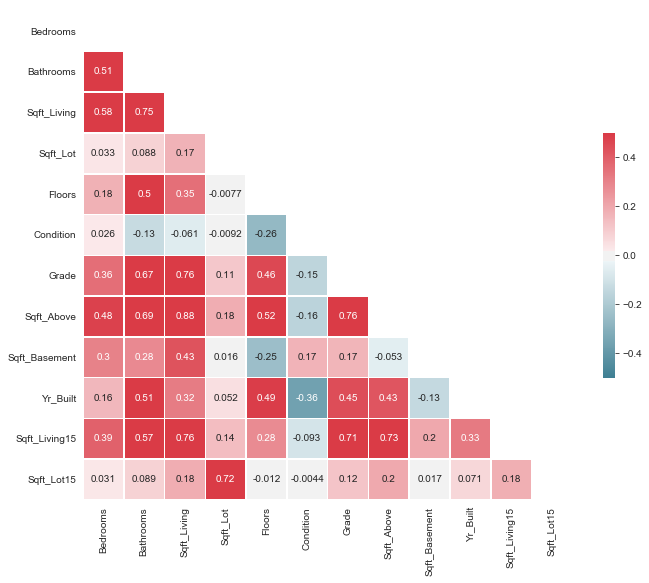

In [27]:
predictors = kc.drop(labels = 'Price', axis = 1)
sns.set_style('white')
corr = predictors.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, vmin = -0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.show()
sns.set_style()

The correlation matrix shows that many of these variables correlate with each other. I suppose I'm not surprised by this. After all, a more expensive house tends to have more bedrooms, bathrooms, space, and floors. Additionally, it is likely to have a higher grade and be newer. So, those things tend to go together and intuitively they will be correlated.

From the description of the columns, I don't think that we need to keep all three of: Sqft_living, Sqft_Above, and Sqft_Basement. Sqft_Above indicates the area of the house above the basement. It is likely that the sum of the area above the basement and the basement area is almost always the "living area". I'll check this assumption quickly. If this mostly holds true, then I'll drop "living area", if not then I'll drop "above".

In [28]:
print(((kc.Sqft_Above+kc.Sqft_Basement)==kc.Sqft_Living).sum()) #This is the number of houses whose area above and below matches total area
print(len(kc.Price))

21081
21081


How wonderful! It's a perfect match, so I'll drop Sqft_Living since it's accounted for in the sum of basement and above area.

In [29]:
kc.drop('Sqft_Living', axis = 1, inplace = True)

In [30]:
predictors.drop('Sqft_Living', axis = 1, inplace = True)

Now I'll look at predictors that measure the difference between the house itself and the houses of neighbors. The interesting thing to look at here, I think, is the houses that are NOT like their neighbors. I imagine that this is where differences arise, so it might be best to create new categories for these comparators that determines if the neighbors are bigger, smaller, or the same. To do this, I'll look at the differences between the house itself and its neighbors for each of these categories.

#### 3.3.1 Analyzing data of neighbors

In [31]:
neighbors_data = pd.DataFrame()
neighbors_data['Lot_Difference'] = (predictors.Sqft_Lot - predictors.Sqft_Lot15)/predictors.Sqft_Lot15
neighbors_data['Living_Difference'] = (predictors.Sqft_Above + predictors.Sqft_Basement - predictors.Sqft_Living15)/predictors.Sqft_Living15

In [32]:
neighbors_data.describe()

,Lot_Difference,Living_Difference
count,21081.000000,21081.000000
mean,0.134628,0.053163
std,1.293415,0.320523
min,-0.945028,-0.812721
25%,-0.063227,-0.118881
50%,0.000000,0.000000
75%,0.093828,0.161039
max,86.527179,5.000000


The descriptive data alone tells us that there are outliers in the data. I'll look at histograms to determine the cutoffs for outliers.

In [33]:
@interact
def lot_difference(
              low_lot = (-0.5,0,0.01),
              high_lot = (0,0.5,0.01),
              low_living = (-0.5,0,0.01),
              high_living = (0,0.5,0.01)):
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16,9))
    
    title = "Distribution of Lot Difference"
    data = neighbors_data.Lot_Difference
    #lower_bound = data.quantile(low_lot)
    #upper_bound = data.quantile(high_lot)
    data = data[(data > low_lot) & (data < high_lot)]
    sns.distplot(data, ax = ax1)
    std_text = 'std: {:1.3f}'.format(data.std())
    ax1.text(0.5, 
             0.8, 
             std_text, 
             horizontalalignment='left',
             verticalalignment='top',
             fontsize = 16,
             transform=ax.transAxes)
    ax1.set_title('Scaled Lot Area Difference')
    
    title = "Distribution of Living Difference"
    data = neighbors_data.Living_Difference
    #lower_bound = data.quantile(low_living)
    #upper_bound = data.quantile(high_living)
    data = data[(data > low_living) & (data < high_living)]
    sns.distplot(data, ax = ax2)
    std_text = 'std: {:1.3f}'.format(data.std())
    ax2.text(1.5, 
             0.8, 
             std_text, 
             horizontalalignment='left',
             verticalalignment='top',
             fontsize = 16,
             transform=ax.transAxes)
    ax2.set_title('Scaled Living Area Difference')
    plt.show()

interactive(children=(FloatSlider(value=-0.25, description='low_lot', max=0.0, min=-0.5, step=0.01), FloatSlid…

The values center at 0, which makes sense because of the way that house lots and houses are constructed. Given this, it makes sense to define an intuitive value for which someone would pay more or less money. I'll assume that at ±10% of the size of the neighbors, the value of the house in question is likely to be significantly different than the the market vaulue of houses that are similar in size. That being said, I'll make categories that define houses that are above and below the regional value. Just to check my assumption, I'll look at the fraction of houses that are withing ±10% of 0 on the next line.

In [34]:
print(((neighbors_data.Living_Difference > -0.50) & (neighbors_data.Living_Difference < 0.50)).sum()/len(neighbors_data.Living_Difference)*100)
print(((neighbors_data.Lot_Difference > -0.50) & (neighbors_data.Lot_Difference < 0.50)).sum()/len(neighbors_data.Lot_Difference)*100)

90.80214411081067
90.03367961671648


±50% of a difference between sizes in living space and lot size account for 90% of the data in both categories. I think that enough of the data is represented in all the categories, and intuitively ±50% of a difference in size would almost certainly make a difference for the average consumer. I'll make categories for the values that are above and below this cutoff.

Of course, if this turns out not to be a significant factor in the model then my intuition is incorrect OR the data simply doesn't support a difference in price. I'll assess this after the model is built.

In [35]:
neighbors_data['Living_Over50'] = (neighbors_data.Living_Difference > 0.50).astype('category')
neighbors_data['Living_Under50'] = (neighbors_data.Living_Difference < -.50).astype('category')
neighbors_data['Lot_Over50'] = (neighbors_data.Lot_Difference > 0.50).astype('category')
neighbors_data['Lot_Under50'] = (neighbors_data.Lot_Difference < -0.50).astype('category')

In [36]:
kc['Living_Over50'] = neighbors_data.Living_Over50
kc['Living_Under50'] = neighbors_data.Living_Under50
kc['Lot_Over50'] = neighbors_data.Lot_Over50
kc['Lot_Under50'] = neighbors_data.Lot_Under50
kc.drop(labels = ['Sqft_Living15', 'Sqft_Lot15'], axis = 1, inplace = True)

Now I'll look at those new categories to see if there is a marked difference.

In [37]:
@interact
def violin_plot(x=['Living_Under50', 'Living_Over50', 'Lot_Under50', 'Lot_Over50'], 
                yscale = ['log', 'linear'],
                hue = ['None', 'Living_Under50', 'Living_Over50', 'Lot_Under50', 'Lot_Over50']):
    
    fig, ax = plt.subplots(1,1,figsize = (12,8))
    if (hue != 'None') & (hue != x):
        title = "Price vs. " + x + " sorted by " + hue
        hue = kc[hue]
    else:
        hue = None
        title = "Price vs. " + x
    
    
    sns.violinplot(x = kc[x], 
                   y = kc.Price, 
                   cut = 0,
                   scale = 'area',
                   inner = 'box',
                   hue = hue,
                   ax = ax,
                   )
    plt.yscale(yscale)
    plt.title(title)

interactive(children=(Dropdown(description='x', options=('Living_Under50', 'Living_Over50', 'Lot_Under50', 'Lo…

It is clear that there is a difference in the price for some of these violin plots. This is especially true when looking at the combined data.

### 3.4 Dropping Data
Now I have to make some decisions about which numerical series to drop. I'll look at the correlations first.

In [38]:
kc.corr().Price.sort_values(ascending = False)

Price            1.000000
Grade            0.668215
Sqft_Above       0.605468
Bathrooms        0.525011
Sqft_Basement    0.323002
Bedrooms         0.308414
Floors           0.256579
Sqft_Lot         0.088399
Yr_Built         0.054792
Condition        0.034706
Name: Price, dtype: float64

Condition, Yr_Built, and Sqft_Lot are not well correlated, so they will be dropped from the dataframe. Floors are also not well correlated and it is more highly correlated with Sqft_above, so that will be dropped too.

In [39]:
kc.drop(labels = ['Condition','Yr_Built', 'Sqft_Lot','Floors'], axis = 1, inplace = True)

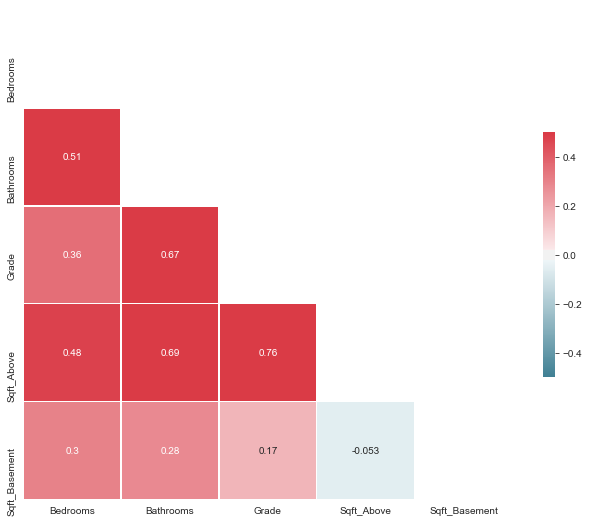

In [40]:
sns.set_style('white')
corr = kc.drop(labels = 'Price', axis = 1).corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, vmin = -0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.show()
sns.set_style()

This is better, but there is still correlation between predictors. I will drop more features from the dataframe if this multicollinearity becomes a problem in the model. For now, I'm content with the results and I'll move on to analyzing the effect of the zip code and month on price.
<br>
<br>
### 3.5  Managing Month and Zipcode
Zipcode is a categorical series with too many unique values to be functionally useful. RFE will take forever if there are too many dummy variables, and deciding which dummy variables to use is somewhat arbitrary based on the total number of features. It might be best to perform target encoding with the zipcode. I'll do the same for months, though I could leave months as a categorical variable and hot-encode if the correlation is low.

In [41]:
zip_means = kc.groupby('Zipcode')['Price'].mean()
month_means = kc.groupby('Month')['Price'].mean()
kc['Zipcode_Means'] = kc.Zipcode.map(zip_means)
kc['Month_Means'] = kc.Month.map(month_means)
print('Zipcode Means : Price\t' + str(kc.corr().loc['Zipcode_Means','Price']))
print('Month : Price\t\t' + str(kc.corr().loc['Month_Means','Price']))

Zipcode Means : Price	0.6392238778761902
Month : Price		0.039301703113603696


The correlation between Zipcode Means and Price is high, so I'll keep the target encoding and drop the Zipcodes. The correlation between Month and Price is very low, so I'll one-hot encode.

In [42]:
kc.drop('Zipcode', axis = 1, inplace = True)

In setting the dummies I found out that the dataset has duplicate entries for single ids. I'll drop the duplicates and reset the index.

In [43]:
kc = kc.reset_index().drop_duplicates(subset = 'id')
kc['id'] = kc.id.astype('int')
kc = kc.set_index('id')

In [44]:
month_dummies = pd.get_dummies(kc.Month)
kc = kc.join(month_dummies,on = 'id')
kc.drop(labels = ['Month', 'Month_Means'], axis = 1, inplace = True)

I will also drop the last month, September, since it is encoded in the other month variables (if not every other month, then it must be September). This will ensure that statsmodel doesn't inject another intercept unknowingly. 

In [45]:
kc.drop(labels = 'September', axis = 1, inplace = True)

#### 3.6 Converting categorical data to uint8
This is a silly step, but I have discovered that statsmodel behaves strangely when categorical data is passed to it. Statsmodel calculates an intercept when categorical data is passed into statsmodel appropriately even if the intercept has been explicitly removed.

In [46]:
columns = kc.select_dtypes('category')
for column in columns:
    kc[column] = kc[column].astype('uint8')

In [47]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20908 entries, 7129300520 to 1523300157
Data columns (total 26 columns):
Price             20908 non-null float64
Bedrooms          20908 non-null int64
Bathrooms         20908 non-null float64
Waterfront        20908 non-null uint8
View              20908 non-null uint8
Grade             20908 non-null int64
Sqft_Above        20908 non-null int64
Sqft_Basement     20908 non-null float64
Basement          20908 non-null uint8
Renovated         20908 non-null uint8
Living_Over50     20908 non-null uint8
Living_Under50    20908 non-null uint8
Lot_Over50        20908 non-null uint8
Lot_Under50       20908 non-null uint8
Zipcode_Means     20908 non-null float64
April             20908 non-null uint8
August            20908 non-null uint8
December          20908 non-null uint8
February          20908 non-null uint8
January           20908 non-null uint8
July              20908 non-null uint8
June              20908 non-null uint8
March      

### 3.6 Scatter Plots
The data has been cleaned up and I now have a better sense of what to do when building the model. Now I can look at scatter plots to better understand the relatioship between the predictors and the target.

One thing that I'll explore are fits for discrete data based on the median at each value. This will give me a better sense of the function that best fits each curve, which I can leverage to linearize the data before I run MLS.

After making the graphs I noticed that there's a house with 33 bedrooms whose price and living area do not corroborate the number of bedrooms. I'll drop it from the dataframe since I can't be certain that it's supposed to have 3 bedrooms instead. That being said, I want to investigate the maximum values again to make sure that I haven't missed any other obvious outliers. I'll look at the scatter plots again after I've gone through the data more carefully.

In [48]:
kc.describe()

,Price,Bedrooms,Bathrooms,Waterfront,View,Grade,Sqft_Above,Sqft_Basement,Basement,Renovated,...,August,December,February,January,July,June,March,May,November,October
count,2.090800e+04,20908.000000,20908.000000,20908.000000,20908.000000,20908.000000,20908.000000,20908.000000,20908.000000,20908.000000,...,20908.000000,20908.000000,20908.000000,20908.000000,20908.000000,20908.000000,20908.000000,20908.000000,20908.000000,20908.000000
mean,5.407252e+05,3.373302,2.118603,0.006744,0.098336,7.662761,1791.673426,291.591783,0.393103,0.034341,...,0.090444,0.068204,0.056820,0.044528,0.103453,0.101684,0.085757,0.112349,0.065382,0.087287
std,3.672884e+05,0.924090,0.768043,0.081845,0.297775,1.171992,829.357329,442.202093,0.488451,0.182108,...,0.286823,0.252101,0.231505,0.206271,0.304557,0.302239,0.280011,0.315803,0.247204,0.282262
min,7.800000e+04,1.000000,0.500000,0.000000,0.000000,4.000000,370.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.225000e+05,3.000000,1.750000,0.000000,0.000000,7.000000,1200.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,0.000000,0.000000,7.000000,1560.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,0.000000,0.000000,8.000000,2220.000000,560.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.700000e+06,33.000000,8.000000,1.000000,1.000000,13.000000,9410.000000,4820.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Everything else looks okay. I'll get rid of the house with 33 bedrooms and then check again.

In [49]:
kc.drop(labels = kc.loc[kc.Bedrooms == 33].index, inplace = True)

In [50]:
kc.Bedrooms.describe()

count    20907.000000
mean         3.371885
std          0.901108
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: Bedrooms, dtype: float64

This looks much better. I'll continue by exploring the scatter plots of the median values.

In [51]:
@interact
def discrete_plot(x = ['Bedrooms', 'Bathrooms', 'Grade', 'Zipcode_Means'],
                  y_function = ['linear', 'log'],
                  x_function = ['linear', 'log', 'squared', 'square-root', 'exp']):
    
    fig, ax = plt.subplots(1,1,figsize = (12,8))
    df = pd.DataFrame(kc.groupby(x).Price.median()).reset_index()
    x = df[x]
    y = df.Price
    def function_mapping(data, function):
        function_map = {'linear':data,
                            'log':data.apply(np.log10), 
                            'squared':data.apply(np.square),
                            'square-root':data.apply(np.sqrt), 
                            'exp':data.apply(np.exp)}
        return function_map[function]
    
    x = function_mapping(x,x_function)
    y = function_mapping(y,y_function)
    corr = np.corrcoef(x,y)
    corr_text = 'corr: {:1.3f}'.format(corr[1,0])
    sns.scatterplot(x = x, y = y)
    plt.text(.025, 
             0.95, 
             corr_text, 
             horizontalalignment='left',
             verticalalignment='top',
             fontsize = 16,
             transform=ax.transAxes)
    plt.show()
    

interactive(children=(Dropdown(description='x', options=('Bedrooms', 'Bathrooms', 'Grade', 'Zipcode_Means'), v…

It appears that taking the log of the price data helps linearize overall. This also helps because the distribution of the price data is normal when it is log transformed. The following relationships have the best correlation values:

| Relationship                 | Correlation Value |
| ---------------------------- | :---------------: |
| log(Price) ~ log(Bedrooms)   | 0.871             |
| log(Price) ~ sqrt(Bathrooms) | 0.867             |
| log(Price) ~ $Grade^2$       | 0.998             |
| log(Price) ~ log(Zipcode)    | 0.992             |

In [52]:
@interact
def scatter_plot(x = ['Sqft_Above','Sqft_Basement'],
                 x_function = ['linear', 'log', 'squared', 'square-root', 'exp'],
                 hue = ['None', 'Waterfront', 'View', 'Basement', 'Renovated']):
    
    fig, ax = plt.subplots(1,1,figsize = (12,8))
    def function_mapping(data, function):
        function_map = {'linear':data,
                            'log':data.apply(np.log10), 
                            'squared':data.apply(np.square),
                            'square-root':data.apply(np.sqrt), 
                            'exp':data.apply(np.exp)}
        return function_map[function]
    x_data = kc.loc[kc[x] > 0][x]
    x_data = function_mapping(x_data,x_function)
    y_data = kc.loc[kc[x] > 0]['Price']
    y_data = y_data.apply(np.log10)
        
    if (hue != 'None'):
        hue = kc[hue]
    else:
        hue = None
    
    corr = np.corrcoef(x_data,y_data)
    corr_text = 'corr: {:1.3f}'.format(corr[1,0])
    plt.text(.025, 
             0.95, 
             corr_text, 
             horizontalalignment='left',
             verticalalignment='top',
             fontsize = 16,
             transform=ax.transAxes)
    
    sns.scatterplot(x = x_data, y = y_data, hue = hue, ax=ax)
    plt.show()

interactive(children=(Dropdown(description='x', options=('Sqft_Above', 'Sqft_Basement'), value='Sqft_Above'), …

While not transforming the predictors yields the best correlation values, I'm concerned that there will be a non-random pattern in the residuals if they're left alone. Log transforming Sqft_Above and taking the square root of Sqft_Basement will yield a random residual pattern in both. This relationship and the correlation values is shown below.

|Relationship|Correlation Value|
|---|---|
|log(Price) ~ log(Sqft Above)| 0.586 |
|log(Price) ~ $SqftBasement^{1/2}$ | 0.374 |

<a id="4"></a>
## 4. Modeling Data

In [53]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

First, I'll transform the data based on the analysis that I performed above.

In [54]:
kc_transformed = kc.copy()
transform = {'Price':np.log10, 
             'Bedrooms':np.log10, 
             'Bathrooms':np.sqrt, 
             'Grade':np.square, 
             'Sqft_Above':np.log10, 
             'Sqft_Basement':np.sqrt,
             'Zipcode_Means':np.log10}

for column in list(kc.columns):
    if column in transform.keys():
        kc_transformed[column] = kc_transformed[column].apply(transform[column])
kc_transformed.describe()

,Price,Bedrooms,Bathrooms,Waterfront,View,Grade,Sqft_Above,Sqft_Basement,Basement,Renovated,...,August,December,February,January,July,June,March,May,November,October
count,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000,...,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000,20907.000000
mean,5.667100,0.511599,1.430697,0.006744,0.098340,60.091931,3.212434,10.294986,0.393074,0.034343,...,0.090448,0.068207,0.056823,0.044531,0.103458,0.101641,0.085761,0.112355,0.065385,0.087291
std,0.228687,0.122320,0.267827,0.081847,0.297781,19.175547,0.185476,13.623514,0.488445,0.182112,...,0.286830,0.252107,0.231510,0.206276,0.304564,0.302182,0.280017,0.315810,0.247210,0.282268
min,4.892095,0.000000,0.707107,0.000000,0.000000,16.000000,2.568202,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.508530,0.477121,1.322876,0.000000,0.000000,49.000000,3.079181,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.653213,0.477121,1.500000,0.000000,0.000000,49.000000,3.193125,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.809560,0.602060,1.581139,0.000000,0.000000,64.000000,3.346353,23.664319,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.886491,1.041393,2.828427,1.000000,1.000000,169.000000,3.973590,69.426220,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


I will normalize the data since the range for each column is significantly different from the others.

In [55]:
kc_transformed_scaled = kc_transformed.copy()
to_scale = kc_transformed_scaled.select_dtypes(include = [np.number]).columns
for column in list(to_scale):
    data = kc_transformed_scaled[column]
    kc_transformed_scaled[column] = (data - data.min())/(data.max()-data.min())
kc_transformed_scaled.agg(['min', 'max'])

,Price,Bedrooms,Bathrooms,Waterfront,View,Grade,Sqft_Above,Sqft_Basement,Basement,Renovated,...,August,December,February,January,July,June,March,May,November,October
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Wonderful! Now I can build the model using the transformed and scaled data. I'll make training and testing sets to work with from now on. First I'll make the formula.

In [56]:
predictors = kc_transformed_scaled.drop(labels = 'Price', axis = 1).copy()
target = kc_transformed_scaled.Price.copy()
predictor_list = list(predictors.columns)
formula = 'Price ~ ' + ' + '.join(list(predictors.columns)) + ' - 1'
print(formula)
print(len(predictors.columns))

Price ~ Bedrooms + Bathrooms + Waterfront + View + Grade + Sqft_Above + Sqft_Basement + Basement + Renovated + Living_Over50 + Living_Under50 + Lot_Over50 + Lot_Under50 + Zipcode_Means + April + August + December + February + January + July + June + March + May + November + October - 1
25


This formula accounts for all 26 predictors. I'm concerned about two things: 1) this is way too many predictors, so the model may not be sensical, and 2) there is likely still correlation between predictors. It will be easy to see if there are indeed to many predictors - the model will have some predictors whose coefficients are not statistically significant if too many predictors are confounding the results. It should also be easy to see if correlation between predictors is causing a problem by checking the values of the coefficients against our understanding of the problem. For example, we know that more bedrooms, more bathrooms, and more space indicate a higher price. If any of these coefficients are negative, then it stands to reason that interactions between the predictors is causing a problem in the model. I'll perform a multiple linear regression and look at the outputs.

The train/test set is made below.

In [57]:
from sklearn.model_selection import train_test_split

predictor_train, predictor_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.20, random_state=42) # Seed with 42 for reproducibility

In [58]:
mod = smf.ols(formula=formula, data = predictor_train.join(target_train))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 4.752e+04
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:13:08   Log-Likelihood:                 27162.
No. Observations:               16725   AIC:                        -5.427e+04
Df Residuals:                   16700   BIC:                        -5.408e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Bedrooms           0.0343      0.004      8.826      0.000       0.027       0.042
Bathrooms         -0.0094      0.005     -2.006      0.045      -0.019      -0.000
Waterfront         0.1086      0.005     22.764      0.000       0.099       0.118
View               0.0381      0.001     27.905      0.000       0.035       0.041
Grade              0.1882      0.005     37.683      0.000       0.178       0.198
Sqft_Above         0.3258      0.006     56.213      0.000       0.314       0.337
Sqft_Basement      0.0656      0.006     11.156      0.000       0.054       0.077
Basement           0.0199      0.002      8.820      0.000       0.015       0.024
Renovated          0.0215      0.002     10.622      0.000       0.018       0.026
Living_Over50      0.0061      0.001      4.104      0.000       0.003       0.009
Living_Under50     0.0331      0.003     10.438      0.000       0.027       0.039
Lot_Over50         0.0112      0.001      7.962      0.000       0.008       0.014
Lot_Under50       -0.0069      0.003     -2.523      0.012      -0.012      -0.002
Zipcode_Means      0.3547      0.002    160.414      0.000       0.350       0.359
April              0.0390      0.002     24.745      0.000       0.036       0.042
August             0.0235      0.002     14.476      0.000       0.020       0.027
December           0.0229      0.002     12.925      0.000       0.019       0.026
February           0.0264      0.002     13.932      0.000       0.023       0.030
January            0.0206      0.002     10.083      0.000       0.017       0.025
July               0.0228      0.002     14.504      0.000       0.020       0.026
June               0.0253      0.002     16.086      0.000       0.022       0.028
March              0.0314      0.002     19.062      0.000       0.028       0.035
May                0.0274      0.002     17.885      0.000       0.024       0.030
November           0.0219      0.002     12.222      0.000       0.018       0.025
October            0.0230      0.002     14.024      0.000       0.020       0.026
==============================================================================
Omnibus:                      394.011   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              920.264
Skew:                           0.028   Prob(JB):                    1.47e-200
Kurtosis:                       4.148   Cond. No.                         21.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Woah! An $r^2$ value of 0.986! This model clearly fits the training data very well, though the same may not be the case for the test data. There are other problems, too. The fact that predictors are correlated with each other is causing problems that show up as non-sensical coefficient estimates. There is a negative correlation for bathrooms (!), for example. I'll perform RFE with cross validation in order to obtain a better model, though I imagine that I'll likely end up with the same problems since RFE only looks to optimize $r^2$, RMSE, or other similar indicators. Maybe this is an opportunity to build my own forward selector?


In [59]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

In [60]:
estimator = SVR(kernel = 'linear')
selector = RFECV(estimator = estimator, cv = 3, scoring = 'neg_mean_squared_error')

In [61]:
selector = selector.fit(predictor_train, target_train)

In [62]:
RFE_predictors = predictor_train.columns[selector.get_support()]

In [63]:
formula = 'Price ~ ' + ' + '.join(RFE_predictors) + ' - 1'
print(formula)

Price ~ Bedrooms + Bathrooms + Waterfront + View + Grade + Sqft_Above + Sqft_Basement + Basement + Renovated + Lot_Over50 + Lot_Under50 + Zipcode_Means + April + May - 1


In [64]:
mod = smf.ols(formula=formula, data = predictor_train.join(target_train))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 8.156e+04
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:13:56   Log-Likelihood:                 26830.
No. Observations:               16725   AIC:                        -5.363e+04
Df Residuals:                   16711   BIC:                        -5.352e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Bedrooms          0.0595      0.004     15.837      0.000       0.052       0.067
Bathrooms        -0.0154      0.005     -3.206      0.001      -0.025      -0.006
Waterfront        0.1104      0.005     22.685      0.000       0.101       0.120
View              0.0379      0.001     27.300      0.000       0.035       0.041
Grade             0.1796      0.005     35.426      0.000       0.170       0.189
Sqft_Above        0.3471      0.006     60.324      0.000       0.336       0.358
Sqft_Basement     0.0520      0.006      8.945      0.000       0.041       0.063
Basement          0.0270      0.002     11.995      0.000       0.023       0.031
Renovated         0.0223      0.002     10.784      0.000       0.018       0.026
Lot_Over50        0.0123      0.001      8.609      0.000       0.009       0.015
Lot_Under50      -0.0028      0.003     -0.995      0.320      -0.008       0.003
Zipcode_Means     0.3632      0.002    163.905      0.000       0.359       0.368
April             0.0183      0.001     14.655      0.000       0.016       0.021
May               0.0069      0.001      5.798      0.000       0.005       0.009
==============================================================================
Omnibus:                      388.945   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              845.487
Skew:                           0.097   Prob(JB):                    2.54e-184
Kurtosis:                       4.084   Cond. No.                         20.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model is not siginficantly better than the previous with regards to the problems identified.  There are still problems with correlation between predictors, and there are some predictors whose coefficients are not statistically significant. It's a shame that SKLearn's RFE can't catch this. I will eliminate the predictors that are insignificant and one of the offending multicollinear predictors (Bathrooms), and then rebuild the model.

In [65]:
RFE_predictors = list(RFE_predictors)
RFE_predictors.remove('Lot_Under50')
RFE_predictors.remove('Bathrooms')

In [66]:
formula = 'Price ~ ' + ' + '.join(RFE_predictors) + ' - 1'
print(formula)

Price ~ Bedrooms + Waterfront + View + Grade + Sqft_Above + Sqft_Basement + Basement + Renovated + Lot_Over50 + Zipcode_Means + April + May - 1


In [67]:
mod = smf.ols(formula=formula, data = predictor_train.join(target_train))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 9.509e+04
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:13:56   Log-Likelihood:                 26824.
No. Observations:               16725   AIC:                        -5.362e+04
Df Residuals:                   16713   BIC:                        -5.353e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Bedrooms          0.0582      0.004     15.581      0.000       0.051       0.066
Waterfront        0.1102      0.005     22.663      0.000       0.101       0.120
View              0.0381      0.001     27.443      0.000       0.035       0.041
Grade             0.1763      0.005     35.444      0.000       0.167       0.186
Sqft_Above        0.3395      0.005     64.898      0.000       0.329       0.350
Sqft_Basement     0.0503      0.006      8.724      0.000       0.039       0.062
Basement          0.0266      0.002     11.846      0.000       0.022       0.031
Renovated         0.0220      0.002     10.672      0.000       0.018       0.026
Lot_Over50        0.0126      0.001      8.824      0.000       0.010       0.015
Zipcode_Means     0.3635      0.002    164.525      0.000       0.359       0.368
April             0.0183      0.001     14.654      0.000       0.016       0.021
May               0.0069      0.001      5.803      0.000       0.005       0.009
==============================================================================
Omnibus:                      392.601   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              845.935
Skew:                           0.106   Prob(JB):                    2.03e-184
Kurtosis:                       4.081   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
y_hat = res.predict(predictor_test)
residuals = target_test - y_hat
MSE_test = (residuals**2).sum()/len(residuals)
MSE_train = res.mse_resid
print('MSE of test data:\t' + str(MSE_test))
print('MSE of train data:\t' + str(MSE_train))

MSE of test data:	0.0023835790441279953
MSE of train data:	0.0023700182830699466


The MSE of the train and test dataset are nearly identical, which tells me that the test data is well approximated by a model derived from the training data. I'll look at the residuals below to check for heteroscedasticity and non-random patterns.

In [77]:
@interact
def residuals_plot(x = RFE_predictors):
    fig, ax = plt.subplots(1,1,figsize = (12,8))
    sns.scatterplot(x = predictor_test[x], y = residuals, ax = ax)
    ax.set_title('Residual plot for ' + x)
    ax.set_ylabel('Residual')
    corr = np.corrcoef(predictor_test[x],residuals)
    corr_text = 'corr: {:1.3f}'.format(corr[1,0])
    plt.text(.875, 
             0.95, 
             corr_text, 
             horizontalalignment='left',
             verticalalignment='top',
             fontsize = 16,
             transform=ax.transAxes)
    plt.show()

interactive(children=(Dropdown(description='x', options=('Bedrooms', 'Waterfront', 'View', 'Grade', 'Sqft_Abov…

The residuals look pretty good. There is some pattern for a few of the predictors, but the correlation value does not exceed 0.253 in magnitude I'll look at their distribution as well just to make sure. I expect the distribution to be roughly normal.

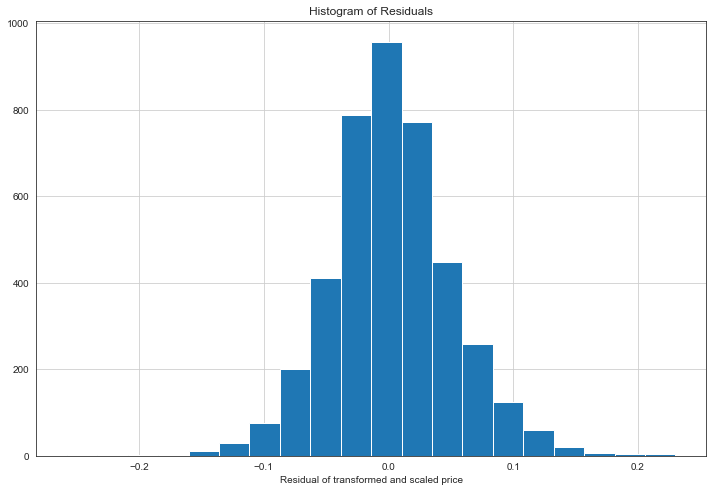

In [70]:
residuals.hist(bins = 20, figsize = (12,8))
plt.title('Histogram of Residuals')
plt.xlabel('Residual of transformed and scaled price')
plt.show()

Now I'll write a function to give an estimate on price given a set of predictors that are not transformed or scaled.

In [71]:
def predict_price(df, alpha = 0.05, kind = 'mean'):
    # Transform the data
    df_transformed = df.copy()
    transform = {'Bedrooms':np.log10, 
                 'Bathrooms':np.sqrt, 
                 'Grade':np.square, 
                 'Sqft_Above':np.log10, 
                 'Sqft_Basement':np.sqrt,
                 'Zipcode_Means':np.log10}

    for column in list(df.columns):
        if column in transform.keys():
            df_transformed[column] = df_transformed[column].apply(transform[column])
    
    # Normalize the data
    kct = kc_transformed.copy()
    scale_factors = {'Bedrooms':{'min':kct.Bedrooms.min(), 'max':kct.Bedrooms.max()},
                     'Bathrooms':{'min':kct.Bathrooms.min(), 'max':kct.Bathrooms.max()},
                     'Grade':{'min':kct.Grade.min(), 'max':kct.Grade.max()},
                     'Sqft_Above':{'min':kct.Sqft_Above.min(), 'max':kct.Sqft_Above.max()}, 
                     'Sqft_Basement':{'min':kct.Sqft_Basement.min(), 'max':kct.Sqft_Basement.max()},
                     'Zipcode_Means':{'min':kct.Zipcode_Means.min(), 'max':kct.Zipcode_Means.max()}}
    
    df_transformed_scaled = df_transformed.copy()
    to_scale = scale_factors.keys()
    for column in list(to_scale):
        data = df_transformed_scaled[column]
        df_transformed_scaled[column] = (data - scale_factors[column]['min'])/(scale_factors[column]['max']-scale_factors[column]['min'])
    
    # Obtain the price interval
    if kind.lower() == 'mean':
        columns = ['mean_ci_lower', 'mean_ci_upper']
    elif kind.lower() == 'obs':
        columns = ['obs_ci_lower', 'obs_ci_upper']
    else:
        raise Exception('Kind can only be "mean" or "obs".')
        
    predictions = res.get_prediction(df_transformed_scaled).summary_frame(alpha = alpha)
    predictions = predictions.loc[:,columns]
    predictions.columns = ['Lower Price Boundary','Upper Price Boundary']
    
    # Denormalize the price interval (also hardcoded based on the dataset)
    predictions = predictions*(kct.Price.max()-kct.Price.min())+kct.Price.min()
    
    # Transform the price interval and return
    predictions = 10**predictions
    predictions['id'] = df.index
    predictions.set_index('id')
    
    return predictions.join(df, on = 'id').set_index('id')

In [72]:
predict_price(kc.head(10),alpha = 0.05, kind = 'obs')

,Lower Price Boundary,Upper Price Boundary,Price,Bedrooms,Bathrooms,Waterfront,View,Grade,Sqft_Above,Sqft_Basement,...,August,December,February,January,July,June,March,May,November,October
id,,,,,,,,,,,,,,,,,,,,,
7129300520,146638.276337,3.522935e+05,221900.0,3,1.00,0,0,7,1180,0.0,...,0,0,0,0,0,0,0,0,0,1
6414100192,357803.817093,8.604426e+05,538000.0,3,2.25,0,0,7,2170,400.0,...,0,1,0,0,0,0,0,0,0,0
5631500400,143516.624615,3.447836e+05,180000.0,2,1.00,0,0,6,770,0.0,...,0,0,1,0,0,0,0,0,0,0
2487200875,273635.296807,6.574556e+05,604000.0,4,3.00,0,0,7,1050,910.0,...,0,1,0,0,0,0,0,0,0,0
1954400510,342247.902926,8.222407e+05,510000.0,3,2.00,0,0,8,1680,0.0,...,0,0,1,0,0,0,0,0,0,0
7237550310,940654.995371,2.261519e+06,1230000.0,4,4.50,0,0,11,3890,1530.0,...,0,0,0,0,0,0,0,1,0,0
2414600126,207545.480005,4.987485e+05,229500.0,3,1.00,0,0,7,1050,730.0,...,0,0,0,0,0,0,0,0,0,0
3793500160,208218.109026,5.002458e+05,323000.0,3,2.50,0,0,7,1890,0.0,...,0,0,0,0,0,0,1,0,0,0
1736800520,468190.203396,1.125547e+06,662500.0,3,2.50,0,0,8,1860,1700.0,...,0,0,0,0,0,0,0,0,0,0


The function `predict_price` provides a range of prices based on the input parameters. An interval for the mean price of a house with a set of attributes can be obtained by passing `kind = 'mean'`, whereas a predictive interval for a single observation can be obtained by passing `kind = 'obs'`.

<a id="5"></a>
## 5. Interpreting the Results